# Exploratory Data Analysis
#### Contents:
- [EDA: Data Cleaning](#EDA%3A-Data-Cleaning)
- [EDA: Stop Words](#EDA%3A-Stop-Words)
- [EDA: Model Preparation](#EDA%3A-Model-Preparation)
---

### Importing libaries

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import time
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
reddit_df = pd.read_csv('./datas/df.csv')
reddit_df.drop('Unnamed: 0', axis=1, inplace=True)

## EDA: Data Cleaning 
---

**What Happened?**

I've check if there's any Null values within my dataframe before I move on to tokenize my context. Then I created three new columns 
    1. tokenized_context: It separates the words in the context into a list of string so we can perform lemmatization and stemmerization.
    2. lemmatize_context: After the context has been tokenized, Then I apply it to lemmatization.
    3. stem_context:After the context has been tokenized, Then I apply it to stem.
    
**What is Lemmatization and stemming?**

They both are two forms of shortening words so we can combine similar forms of the same word. When we "lemmatize" data, we take words and attempt to return their lemma, or the base/dictionary form of a word. When we "stem" data, we take words and attempt to return a base form of the word. It tends to be cruder than using lemmatization. 





In [3]:
reddit_df.head()

,context,rainbow6
0,Yup! It was amazing how quickly they released ...,0
1,"First of all, you are getting better. Because ...",0
2,I'm pretty new to reddit so idrk what you mean...,0
3,Maybe its seems like there is no progress but ...,0
4,"Kalista, just because it explains Hecarims, th...",0


In [4]:
reddit_df.isnull().sum()

context     5
rainbow6    0
dtype: int64

In [5]:
reddit_df.dropna(inplace=True)

In [6]:
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()

In [7]:
reddit_df['tokenized_context'] = reddit_df['context'].apply(lambda x: tokenizer.tokenize(x))

In [8]:
reddit_df['lemmatize_context'] = reddit_df['tokenized_context'].map(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x))

In [9]:
reddit_df['stem_context'] =reddit_df['tokenized_context'].map(lambda x: ' '.join(p_stemmer.stem(word) for word in x))

In [10]:
reddit_df.head()

,context,rainbow6,tokenized_context,lemmatize_context,stem_context
0,Yup! It was amazing how quickly they released ...,0,"[Yup, It, was, amazing, how, quickly, they, re...",Yup It wa amazing how quickly they released ch...,yup It wa amaz how quickli they releas champio...
1,"First of all, you are getting better. Because ...",0,"[First, of, all, you, are, getting, better, Be...",First of all you are getting better Because th...,first of all you are get better becaus the gam...
2,I'm pretty new to reddit so idrk what you mean...,0,"[I, m, pretty, new, to, reddit, so, idrk, what...",I m pretty new to reddit so idrk what you mean...,I m pretti new to reddit so idrk what you mean...
3,Maybe its seems like there is no progress but ...,0,"[Maybe, its, seems, like, there, is, no, progr...",Maybe it seems like there is no progress but t...,mayb it seem like there is no progress but the...
4,"Kalista, just because it explains Hecarims, th...",0,"[Kalista, just, because, it, explains, Hecarim...",Kalista just because it explains Hecarims the ...,kalista just becaus it explain hecarim the twi...


In [11]:
reddit_df.shape

(19995, 5)

## EDA: Stop Words

**Why Stop Words?**

I added many additional stopwords into the default 'english'. To be able to make my data more pure, I obtained and include the champions names from League of Legends website and Operators names from Rainbow Six website, and added into our stopwords list, so those words won't let our model too easily predict the result.

In [14]:
url = 'https://www.lol-smurfs.com/blog/league-of-legends-champions-list/'
urlr = 'https://www.rockpapershotgun.com/2018/12/06/rainbow-six-siege-operators-who-to-pick-which-abilities-are-best-2/'
res= requests.get(url)
res_r= requests.get(urlr)

TooManyRedirects: Exceeded 30 redirects.

In [13]:
soup = BeautifulSoup(res.content, 'lxml')
soup_r = BeautifulSoup(res_r.content, 'lxml')

In [14]:
champions = [tag.text for tag in soup.find_all('td')]

In [15]:
operators = [tag.text for tag in soup_r.find_all('li')]

In [16]:
stopwords = nltk.corpus.stopwords.words('english'.replace('\n',''))
stopwords.append('riot')
stopwords.append('champion')
stopwords.append('champ')
stopwords.append('league')
stopwords.append('operator')
stopwords.append('siege')
stopwords.append('ubi')
stopwords.append('ubisoft')
stopwords.append('r6')
stopwords.append('rainbow')
stopwords.append('irelia')
stopwords.append('blitz')
stopwords.append('neeko')
stopwords.append('six')
stopwords.append('legends')
stopwords.append('nexus')
stopwords.append('aa')
stopwords.append('removed')
stopwords.append('pyke')

In [17]:
for i in champions:
    stopwords.append(i.lower().replace(' ','').replace('\n','').replace('’','').replace('.',''))

In [18]:
for x in operators:
    stopwords.append(x.lower().replace(' ','').replace('\n','').replace('"','').replace('.','').replace("'",""))

# EDA: Data Visualization
---

In [21]:
reddit_df['word_count'] = reddit_df.context.map(lambda x: len(x.split()))
reddit_df['char_count'] = reddit_df.context.map(len)

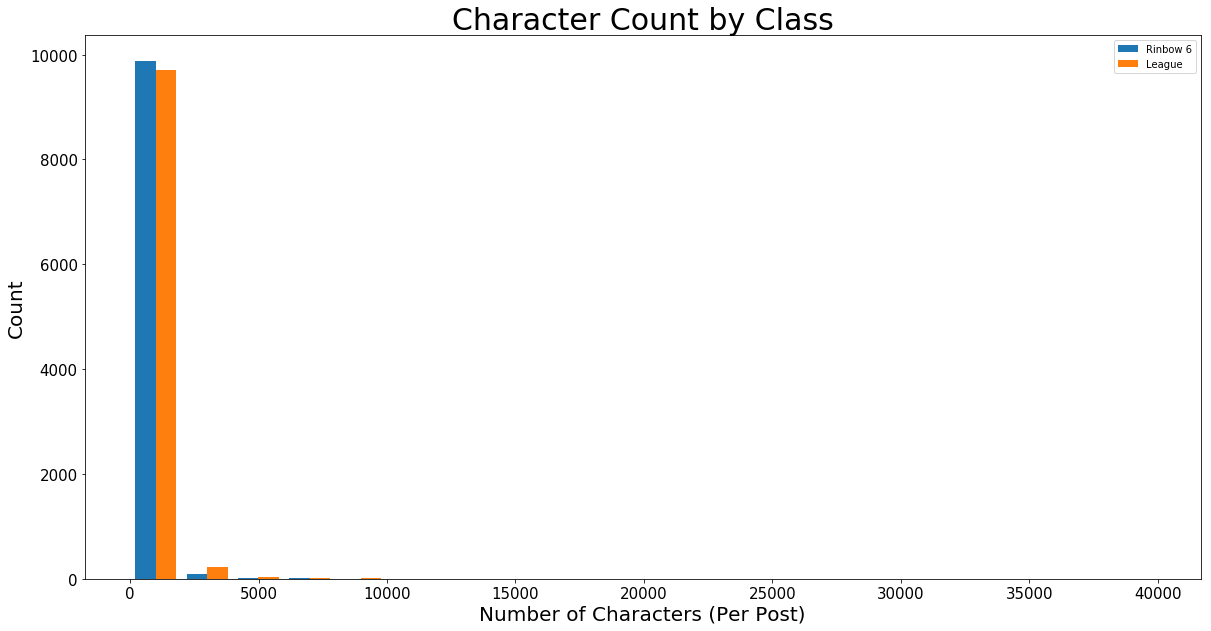

In [25]:
plt.figure(figsize=(20, 10))
plt.hist([reddit_df[reddit_df['rainbow6'] == 1]['char_count'],
         reddit_df[reddit_df['rainbow6'] == 0]['char_count']],
         bins=20)
plt.title('Character Count by Class', fontsize=30)
plt.xlabel('Number of Characters (Per Post)', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Rinbow 6', 'League']);

Most posts contain less than 5000 characters for both subreddits.
r/rainbow 6 has a greater count than r/LoL, but there doesn't appear to be a significant difference to help us determine which subreddit a given post belongs in.

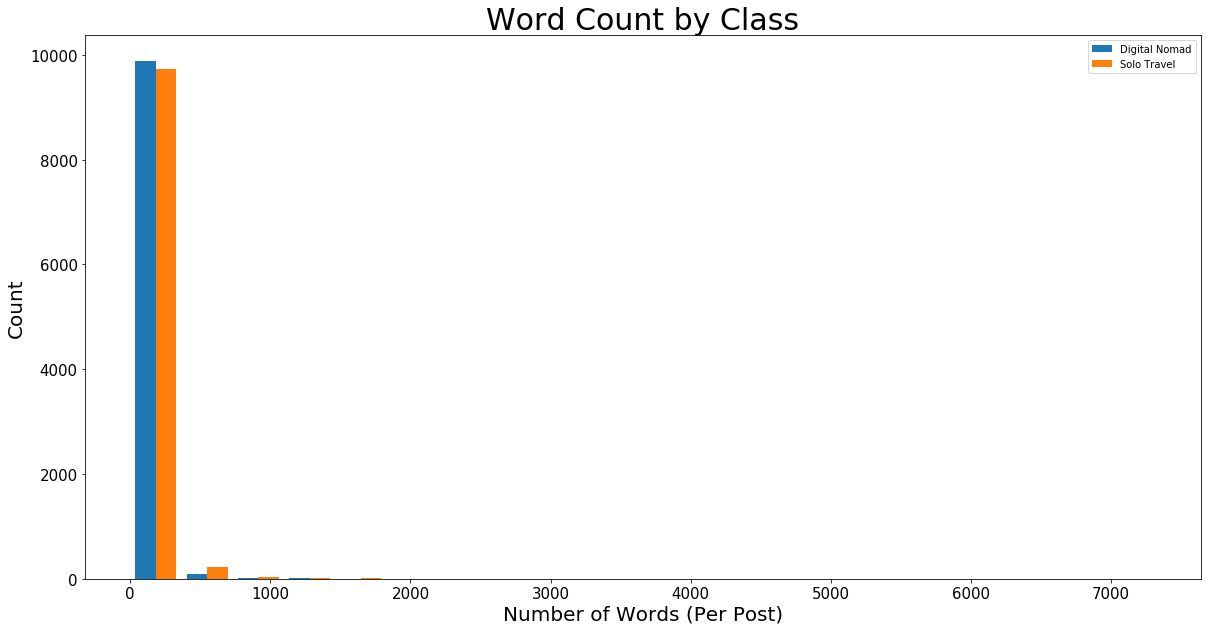

In [27]:
plt.figure(figsize=(20, 10))
plt.hist([reddit_df[reddit_df['rainbow6'] == 1]['word_count'],
         reddit_df[reddit_df['rainbow6'] == 0]['word_count']],
         bins=20)
plt.title('Word Count by Class', fontsize=30)
plt.xlabel('Number of Words (Per Post)', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Digital Nomad', 'Solo Travel']);

Most posts have less than 1000 words for both subreddits.
Again, r/solotravel has a greater count than r/digitalnomad, but there isn't a significant difference to provide any insight.


## EDA
---

From the bar chart, we can see that there's a word count of 1. Given that posts with only 1 word will typically not relay much information or mainly consists of pictures, we'll remove them.

In [28]:
reddit_df[reddit_df['word_count'] <= 1].head()

,context,rainbow6,tokenized_context,lemmatize_context,stem_context,word_count,char_count
8740,[removed]Ide@[removed],0,"[removed, Ide, removed]",removed Ide removed,remov ide remov,1,22
10149,patch[removed],1,"[patch, removed]",patch removed,patch remov,1,15
10163,Prayyoeted,1,[Prayyoeted],Prayyoeted,prayyoet,1,10
11158,r/contagiouslaughterRanked[removed],1,"[r, contagiouslaughterRanked, removed]",r contagiouslaughterRanked removed,r contagiouslaughterrank remov,1,35
12693,yeahPerfection,1,[yeahPerfection],yeahPerfection,yeahperfect,1,14


In [29]:
reddit_df.drop(labels=reddit_df[reddit_df['word_count'] <= 1].index, inplace=True)
reddit_df.reset_index(drop=True, inplace=True)


We want to use CountVectorizer() to visualize the most commonly used words and their frequency to see if there are any obvious differences we can identify immediately. Before doing so, we must tokenize, remove stop words and lemmatize our text.

## EDA: Model Preparation
---

**Why Lemmatize?**
- The reason why I choose lemmatize_context as my final X variable is because I tried the Stemmer_context and the result wasn't ideal. Reason why is because stemmer is an aggressive way to shorten the context. This might lose the meaning of the word itself.

 




In [37]:
X = reddit_df[['lemmatize_context']]
y = reddit_df['rainbow6']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)



**Why Tfidf?**
- Tfidf: This tells us which words are most discriminating between documents. Words that occur a lot in one document but doesn't occur in many documents will tell you something special about the document.
- Tfidf relies on two stats: term frequency, and inverse document frequency

In [21]:
tfidf = TfidfVectorizer(stop_words=stopwords, min_df=20, max_df=.95)


In [22]:
train_raw = tfidf.fit_transform(X_train['lemmatize_context'])

In [23]:
train_df = pd.SparseDataFrame(train_raw, columns=tfidf.get_feature_names())

In [24]:
train_df.fillna(0, inplace=True)
train_df.head()

,abandon,ability,able,absolute,absolutely,absurd,abuse,abused,abusing,academy,...,youtube,youtuber,youtubers,yup,zero,zhao,zix,zoe,zone,zoom
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.263804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Will do the exact same with Test data like our Training Data**

In [25]:
test_df = pd.SparseDataFrame(tfidf.transform(X_test['lemmatize_context']), columns=tfidf.get_feature_names())
test_df.fillna(0, inplace=True)

---
#### Export Train and Test

In [26]:
train_df.to_csv('./datas/train_df.csv')
test_df.to_csv('./datas/test_df.csv')

In [27]:
y_train.to_csv('./datas/y_train.csv')
y_test.to_csv('./datas/y_test.csv')

In [28]:
y.to_csv('./datas/y.csv', index=False, header=False)

In [29]:
X_test.to_csv('./datas/X_test.csv')